In [1]:
import sys
sys.path.append('../../')

from amplify.client import FixstarsClient
from matplotlib import pyplot as plt
import numpy as np
import os

from flow_solver.finite_element_model import FEM
from flow_solver.mesh_generator import MeshDoublePipe
from optimizer import  AnnealingSolver
from problems.topo_opt_level_set_fluid_flow import TopologyOptimizationProblem

# Timeout Analysis for Double Pipe Problem

## Computational Mesh

In [2]:
# Create Meshes for double pipe problem.
n_elem_for_width = 48
n_elem_for_height = 32
mesh_v = MeshDoublePipe('Q2', n_elem_for_width, n_elem_for_height, width=1.5, height=1.0, inlet_height=1./6., outlet_height=1./6.)
mesh_p = MeshDoublePipe('Q1', n_elem_for_width, n_elem_for_height, width=1.5, height=1.0, inlet_height=1./6., outlet_height=1./6.)

## Finite Element Model

### Boundary Conditions

In [3]:
def upper_inlet_velocity(mesh, i_node):
    x = mesh.coords[i_node][0]; y = mesh.coords[i_node][1]
    v_x = 1-144*((y-3/4)**2); v_y = 0.0
    return np.array([v_x, v_y])

In [4]:
def lower_inlet_velocity(mesh, i_node):
    x = mesh.coords[i_node][0]; y = mesh.coords[i_node][1]
    v_x = 1-144*((y-1/4)**2); v_y = 0.0
    return np.array([v_x,v_y])

In [5]:
# Compute boundary velocities.
boundary_velocity = {key: [] for key in mesh_v.boundary_nodes.keys()}
for boundary in mesh_v.boundary_nodes.keys():
    for i_node in mesh_v.boundary_nodes[boundary]:
        if boundary == 'inlet_upper':
            boundary_velocity[boundary].append(upper_inlet_velocity(mesh_v, i_node))
        elif boundary == 'inlet_lower':
            boundary_velocity[boundary].append(lower_inlet_velocity(mesh_v, i_node))
        elif boundary == 'wall':
            boundary_velocity[boundary].append(np.zeros(2))
        if boundary == 'outlet_upper':
            boundary_velocity[boundary].append(upper_inlet_velocity(mesh_v, i_node))
        elif boundary == 'outlet_lower':
            boundary_velocity[boundary].append(lower_inlet_velocity(mesh_v, i_node))

# Set values for Dirichlet boundary conditions.
# Velocity.
BC = []
for boundary in mesh_v.boundary_nodes.keys():
    for i_node, node in enumerate(mesh_v.boundary_nodes[boundary]):
        if (boundary == 'inlet_upper' or 
            boundary == 'inlet_lower' or 
            boundary == 'wall' or 
            boundary == 'outlet_upper' or 
            boundary == 'outlet_lower'):
            BC.append([node, 0, boundary_velocity[boundary][i_node][0]])
            BC.append([node, 1, boundary_velocity[boundary][i_node][1]])
boundary_values_v = np.array(BC)

### Material Properties.

In [6]:
viscosity = 1. 
density = 1.

# 
epsilon = 8.e-2

### Finite Element Model

In [7]:
fem = FEM(mesh_v, mesh_p, viscosity, density, epsilon)
fem.set_boudary_values_v(boundary_values_v)

In [8]:
U, u_e, v_e, p_e, F, f=fem.solve()
objective_initial = F
volume_fraction_initial = 1.0
print(f'Objective Function:{f}')
# fem.plot_velocity_field([u_e, v_e])
# fem.plot_velocity_magnitude([u_e, v_e])
# fem.plot_pressure(p_e)

Objective Function:0.001291177124467389


## Timeout Analysis

In [9]:
# Annealing Solver.
client = FixstarsClient()
client.parameters.timeout = 10000
client.parameters.outputs.duplicate = True
if os.path.exists('token_Fixstars.txt'):
    client.token = open('token_Fixstars.txt',"r").read().replace('\n', '')
if os.path.exists('proxy.txt'):
    client.proxy = open('proxy.txt',"r").read().replace('\n', '')

annealing_solver = AnnealingSolver(client)

In [10]:
# Topology Optimization Problem
n_qubits_per_variable = 9
volume_fraction_max = 1./3. # Volume fraction.
hyperparameters = {
    'energy_dissipation': 1.,
    'regularization': 0.,
    'volume_constraint': 0.05,
    'char_func': 0.,
}
topo_opt_problem = TopologyOptimizationProblem(fem.ne, n_qubits_per_variable, hyperparameters, volume_fraction_max)
topo_opt_problem.generate_discretizaton()
resistance_coeff_solid = fem.viscosity/fem.epsilon
topo_opt_problem.generate_qubo_formulation(u_e, v_e, resistance_coeff_solid, fem.mesh_v.neighbor_elements)

In [11]:
def plot_history(history):
    time = history['sampling_time']
    energy = history['energy']    
    plt.figure(figsize=(4,3))
    plt.plot(time,energy,linestyle='None', marker='o',color='deepskyblue')
    plt.show()

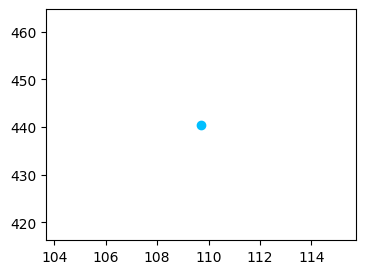

In [12]:
solution, history = annealing_solver.solve_qubo_problem(topo_opt_problem, track_history=True)
plot_history(history)

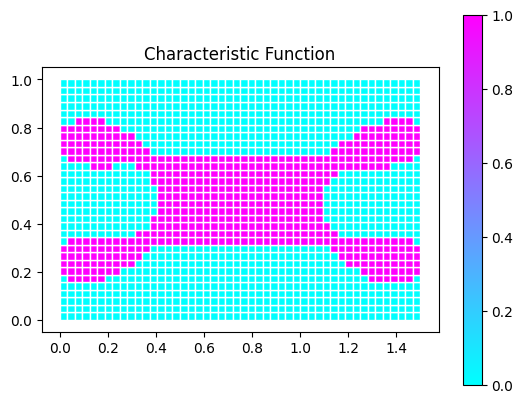

In [13]:
level_set, level_set_scaled, char_func = topo_opt_problem.get_functions_from_binary_solutions(solution[-1])
fem.plot_eva(char_func, title='Characteristic Function')